# Comprehensive Dyslexia Text Simplification Model - Capstone Project

In [1]:

# Import libraries

import warnings
warnings.filterwarnings('ignore')

# Fix NLTK dependencies first
import nltk
try:
    nltk.download('punkt_tab', quiet=True)
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
except:
    pass

# Core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import random
from tqdm.auto import tqdm
import json
import pickle
from pathlib import Path
import os
import time
from datetime import datetime

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
except:
    PLOTLY_AVAILABLE = False
    print("⚠️ Plotly not available, skipping interactive plots")

try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except:
    WORDCLOUD_AVAILABLE = False
    print("⚠️ WordCloud not available, skipping word clouds")

import matplotlib.patches as mpatches

# NLP & ML
import textstat
try:
    import spacy
    SPACY_AVAILABLE = True
except:
    SPACY_AVAILABLE = False
    print("⚠️ spaCy not available, skipping linguistic analysis")

from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Transformers
from transformers import (
    T5ForConditionalGeneration, T5Tokenizer,
    Trainer, TrainingArguments,
    DataCollatorForSeq2Seq,
    EarlyStoppingCallback
)
from datasets import Dataset, load_dataset
import evaluate

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Enhanced plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Device configuration
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("🍎 Using Apple Silicon GPU (MPS)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("🔥 Using NVIDIA GPU")
else:
    device = torch.device("cpu")
    print("💻 Using CPU")



🍎 Using Apple Silicon GPU (MPS)


In [2]:
class AdvancedDataLoader:
    """Advanced data loader with comprehensive analysis capabilities"""
    
    def __init__(self):
        self.wikiauto_data = None
        self.educational_data = None
        self.combined_data = None
        
    def load_wikiauto_dataset(self, subset_size=None):
        """Load WikiAuto dataset with correct handling of nested structure"""
        
        print("📥 Loading WikiAuto dataset...")
        
        try:
            # Load the full WikiAuto dataset
            dataset = load_dataset("wiki_auto", trust_remote_code=True)
            print("✅ WikiAuto dataset loaded successfully!")
            
            # Handle different split names - WikiAuto uses 'part_1' and 'part_2' instead of 'train'
            if 'train' not in dataset:
                if 'part_1' in dataset:
                    # Use part_1 as training data (it's the larger split)
                    dataset['train'] = dataset['part_1']
                    print(f"📋 Using 'part_1' as training data: {len(dataset['part_1']):,} examples")
                elif 'part_2' in dataset:
                    # Fallback to part_2 if part_1 not available
                    dataset['train'] = dataset['part_2']
                    print(f"📋 Using 'part_2' as training data: {len(dataset['part_2']):,} examples")
                else:
                    raise KeyError("No suitable training split found")
            
            # Check the actual field names in the dataset
            sample_item = dataset['train'][0]
            print(f"🔍 Available fields: {list(sample_item.keys())}")
            
            # If subset_size is specified, take a sample FIRST before field mapping
            if subset_size and 'train' in dataset and subset_size < len(dataset['train']):
                print(f"📊 Taking subset of {subset_size} examples for development...")
                indices = random.sample(range(len(dataset['train'])), subset_size)
                train_subset = dataset['train'].select(indices)
                dataset['train'] = train_subset
            
            # WikiAuto has nested structure - extract the actual text
            def extract_and_standardize_fields(example):
                try:
                    # Handle the nested structure in WikiAuto
                    if 'normal' in example and 'simple' in example:
                        normal_data = example['normal']
                        simple_data = example['simple']
                        
                        # Extract text from nested structure
                        if isinstance(normal_data, dict):
                            if 'normal_article_content' in normal_data:
                                normal_content = normal_data['normal_article_content']
                                if isinstance(normal_content, dict) and 'normal_sentence' in normal_content:
                                    normal_sentences = normal_content['normal_sentence']
                                    if isinstance(normal_sentences, list) and len(normal_sentences) > 0:
                                        source_text = normal_sentences[0]  # Take first sentence
                                    else:
                                        source_text = str(normal_sentences)
                                else:
                                    source_text = str(normal_content)
                            else:
                                source_text = str(normal_data)
                        else:
                            source_text = str(normal_data)
                        
                        if isinstance(simple_data, dict):
                            if 'simple_article_content' in simple_data:
                                simple_content = simple_data['simple_article_content']
                                if isinstance(simple_content, dict) and 'simple_sentence' in simple_content:
                                    simple_sentences = simple_content['simple_sentence']
                                    if isinstance(simple_sentences, list) and len(simple_sentences) > 0:
                                        target_text = simple_sentences[0]  # Take first sentence
                                    else:
                                        target_text = str(simple_sentences)
                                else:
                                    target_text = str(simple_content)
                            else:
                                target_text = str(simple_data)
                        else:
                            target_text = str(simple_data)
                            
                        example['source'] = source_text
                        example['target'] = target_text
                        
                    else:
                        # Fallback if structure is different
                        example['source'] = "Sample complex text for training."
                        example['target'] = "Sample simple text for training."
                        
                except Exception as e:
                    print(f"⚠️ Error processing example: {e}")
                    example['source'] = "Sample complex text for training."
                    example['target'] = "Sample simple text for training."
                
                return example
            
            # Apply field extraction and standardization
            print("🔄 Extracting and standardizing field names...")
            dataset['train'] = dataset['train'].map(extract_and_standardize_fields)
            print("✅ Field names standardized to 'source' and 'target'")
            
            # Verify the mapping worked and filter out invalid examples
            valid_examples = []
            for item in dataset['train']:
                source = item.get('source', '')
                target = item.get('target', '')
                
                # Only keep examples with meaningful text (not just dict representations)
                if (isinstance(source, str) and isinstance(target, str) and 
                    len(source.strip()) > 10 and len(target.strip()) > 10 and
                    not source.startswith('{') and not target.startswith('{')):
                    valid_examples.append({
                        'source': source,
                        'target': target
                    })
            
            print(f"📊 Filtered to {len(valid_examples)} valid examples")
            
            if len(valid_examples) < 50:
                print("⚠️ Too few valid examples, using fallback dataset...")
                valid_examples = [
                    {
                        'source': "Photosynthesis is a complex biochemical process that occurs in plants, algae, and certain bacteria, converting light energy into chemical energy stored in glucose molecules.",
                        'target': "Plants make food from sunlight. This process is called photosynthesis. Plants use light to make sugar."
                    },
                    {
                        'source': "The mitochondrion is often referred to as the powerhouse of the cell because it generates most of the cell's supply of adenosine triphosphate, used as a source of chemical energy.",
                        'target': "Mitochondria make energy for cells. They are like tiny power plants inside cells."
                    },
                    {
                        'source': "Quantum mechanics is a fundamental theory in physics that describes the behavior of matter and energy at the molecular, atomic, nuclear, and even smaller microscopic levels.",
                        'target': "Quantum mechanics explains how very small things work. It tells us about atoms and particles."
                    },
                    {
                        'source': "The periodic table is a tabular arrangement of the chemical elements, ordered by their atomic number, electron configuration, and recurring chemical properties.",
                        'target': "The periodic table shows all chemical elements. Elements are arranged by their properties."
                    },
                    {
                        'source': "DNA replication is a biological process occurring in all living organisms that copies their DNA; this process is the basis for biological inheritance.",
                        'target': "DNA copying happens in all living things. This is how traits pass from parents to children."
                    }
                ] * 200  # Duplicate to have enough examples
            
            # Create new dataset with clean data
            dataset['train'] = Dataset.from_list(valid_examples[:subset_size] if subset_size else valid_examples)
                        
        except Exception as e:
            print(f"⚠️ Error loading WikiAuto: {e}")
            print("⚠️ Creating sample dataset...")
            sample_data = {
                'source': [
                    "Photosynthesis is a complex biochemical process that occurs in plants, algae, and certain bacteria, converting light energy into chemical energy stored in glucose molecules.",
                    "The mitochondrion is often referred to as the powerhouse of the cell because it generates most of the cell's supply of adenosine triphosphate, used as a source of chemical energy.",
                    "Quantum mechanics is a fundamental theory in physics that describes the behavior of matter and energy at the molecular, atomic, nuclear, and even smaller microscopic levels.",
                    "The periodic table is a tabular arrangement of the chemical elements, ordered by their atomic number, electron configuration, and recurring chemical properties.",
                    "DNA replication is a biological process occurring in all living organisms that copies their DNA; this process is the basis for biological inheritance."
                ] * 200,  # Duplicate to have enough examples
                'target': [
                    "Plants make food from sunlight. This process is called photosynthesis. Plants use light to make sugar.",
                    "Mitochondria make energy for cells. They are like tiny power plants inside cells.",
                    "Quantum mechanics explains how very small things work. It tells us about atoms and particles.",
                    "The periodic table shows all chemical elements. Elements are arranged by their properties.",
                    "DNA copying happens in all living things. This is how traits pass from parents to children."
                ] * 200
            }
            dataset = {'train': Dataset.from_dict(sample_data)}
        
        self.wikiauto_data = dataset
        
        # Display dataset information
        print(f"\n📊 Dataset Information:")
        for split in dataset.keys():
            print(f"   {split}: {len(dataset[split]):,} examples")
        
        # Show sample - now guaranteed to have 'train' split with 'source' and 'target' fields
        if 'train' in dataset and len(dataset['train']) > 0:
            sample = dataset['train'][0]
            print(f"\n📝 Sample Example:")
            
            # Safe access to fields
            source_text = sample.get('source', 'No source field')
            target_text = sample.get('target', 'No target field')
            
            print(f"Source: {str(source_text)[:100]}...")
            print(f"Target: {str(target_text)[:100]}...")
        else:
            print(f"\n⚠️ No training examples available for preview")
            
        return dataset

    
    def create_educational_dataset(self):
        """Create comprehensive educational dataset for domain-specific training"""
        
        educational_content = {
            'mathematics': [
                {
                    'source': "The quadratic formula x = (-b ± √(b² - 4ac)) / 2a is used to solve quadratic equations of the form ax² + bx + c = 0, where a, b, and c are coefficients and a ≠ 0, providing exact solutions for second-degree polynomial equations.",
                    'target': "The quadratic formula helps solve equations with x². The formula is x = (-b ± √(b² - 4ac)) / 2a. Here a, b, and c are numbers from your equation."
                },
                {
                    'source': "Integration is the reverse mathematical operation of differentiation and represents the calculation of the area under a curve or the accumulation of quantities over an interval, fundamental to calculus applications.",
                    'target': "Integration is the opposite of finding slopes. It helps us find the area under curved lines on graphs. It is used in many math problems."
                },
                {
                    'source': "A polynomial is an expression consisting of variables and coefficients, involving only addition, subtraction, multiplication, and non-negative integer exponentiation of variables, forming the basis of algebraic operations.",
                    'target': "A polynomial is a math expression with variables and numbers. You can add, subtract, and multiply the parts. They are used in algebra."
                },
                {
                    'source': "The Pythagorean theorem states that in a right triangle, the square of the length of the hypotenuse equals the sum of squares of the lengths of the other two sides, expressed as a² + b² = c².",
                    'target': "In a right triangle, a² + b² = c². Here c is the longest side, and a and b are the other sides. This helps find missing side lengths."
                }
            ],
            'physics': [
                {
                    'source': "Newton's second law of motion states that the acceleration of an object is directly proportional to the net force acting on it and inversely proportional to its mass, expressed mathematically as F = ma.",
                    'target': "Newton's second law says Force = mass × acceleration. More force makes things speed up faster. Heavier things are harder to speed up."
                },
                {
                    'source': "Electromagnetic radiation consists of oscillating electric and magnetic fields that propagate through space at the speed of light, encompassing radio waves, visible light, and gamma rays across the electromagnetic spectrum.",
                    'target': "Light is made of electric and magnetic waves. These waves move at light speed. Radio, visible light, and X-rays are all the same type of wave."
                },
                {
                    'source': "The conservation of energy principle states that energy cannot be created or destroyed in an isolated system, only transformed from one form to another, maintaining the total energy constant.",
                    'target': "Energy cannot be made or destroyed. It can only change from one type to another type. The total amount of energy stays the same."
                },
                {
                    'source': "Gravitational force is an attractive force between any two objects with mass, proportional to their masses and inversely proportional to the square of the distance between them, as described by Newton's law of universal gravitation.",
                    'target': "Gravity pulls objects together. Bigger objects have stronger gravity. Objects farther apart have weaker gravity between them."
                }
            ],
            'chemistry': [
                {
                    'source': "Covalent bonds form when atoms share electrons to achieve a stable electron configuration, typically following the octet rule where atoms seek eight electrons in their outermost shell for maximum stability.",
                    'target': "Atoms share electrons to make covalent bonds. This sharing helps atoms become stable. Atoms want eight electrons in their outer shell."
                },
                {
                    'source': "The pH scale measures the acidity or alkalinity of a solution, ranging from 0 to 14, where 7 is neutral, values below 7 are acidic, and values above 7 are basic or alkaline.",
                    'target': "pH measures how acidic or basic something is. 7 is neutral. Numbers below 7 are acidic. Numbers above 7 are basic."
                },
                {
                    'source': "Chemical equilibrium occurs when the rate of the forward reaction equals the rate of the reverse reaction, resulting in constant concentrations of reactants and products over time.",
                    'target': "Chemical equilibrium happens when reactions balance out. The forward and backward reactions go at the same speed."
                },
                {
                    'source': "Oxidation-reduction reactions involve the transfer of electrons between substances, where oxidation is the loss of electrons and reduction is the gain of electrons, crucial for many chemical processes.",
                    'target': "In redox reactions, electrons move between substances. Oxidation means losing electrons. Reduction means gaining electrons."
                }
            ],
            'biology': [
                {
                    'source': "Mitosis is a type of cell division that results in two daughter cells each having the same number and kind of chromosomes as the parent nucleus, essential for growth and repair in multicellular organisms.",
                    'target': "Mitosis is when one cell splits into two identical cells. Each new cell has the same genetic information as the parent cell."
                },
                {
                    'source': "Photosynthesis is the complex process by which plants, algae, and some bacteria convert light energy into chemical energy stored in glucose, using carbon dioxide and water in the presence of chlorophyll.",
                    'target': "Plants use sunlight to make sugar for food. They take in carbon dioxide and water. This process is called photosynthesis."
                },
                {
                    'source': "Natural selection is the differential survival and reproduction of individuals due to differences in phenotype, leading to evolutionary changes in populations over time through environmental pressures.",
                    'target': "Natural selection means the best-adapted organisms survive and reproduce. This causes species to change over time."
                },
                {
                    'source': "The central dogma of molecular biology describes the flow of genetic information from DNA to RNA to protein through transcription and translation processes, fundamental to understanding heredity.",
                    'target': "Genetic information flows from DNA to RNA to proteins. This happens through copying and translating genetic codes."
                }
            ],
            'computer_science': [
                {
                    'source': "Object-oriented programming is a programming paradigm based on the concept of objects, which contain data in the form of fields and code in the form of procedures called methods, promoting code reusability and modularity.",
                    'target': "Object-oriented programming groups related data and functions together in objects. This makes code easier to organize and understand."
                },
                {
                    'source': "Machine learning algorithms enable computers to automatically learn and improve from experience without being explicitly programmed for every specific task, utilizing statistical techniques to identify patterns in data.",
                    'target': "Machine learning teaches computers to learn from examples. The computer finds patterns in data by itself without specific instructions."
                },
                {
                    'source': "Data structures are specialized formats for organizing, processing, retrieving and storing data efficiently, such as arrays, linked lists, stacks, queues, trees, and graphs, each optimized for specific operations.",
                    'target': "Data structures are ways to organize information in computers. Examples include lists, stacks, and trees. Each has different uses."
                },
                {
                    'source': "Algorithms are step-by-step procedures or formulas for solving problems, typically implemented in computer programs to perform calculations, data processing, or automated reasoning tasks efficiently.",
                    'target': "Algorithms are step-by-step instructions for solving problems. They tell computers exactly what to do to complete a task."
                }
            ]
        }
        
        # Convert to dataset format
        educational_examples = []
        for subject, examples in educational_content.items():
            for example in examples:
                educational_examples.append({
                    'source': example['source'],
                    'target': example['target'],
                    'subject': subject,
                    'domain': 'educational'
                })
        
        educational_dataset = Dataset.from_list(educational_examples)
        self.educational_data = educational_dataset
        
        print(f"📚 Created educational dataset with {len(educational_examples)} examples")
        print(f"📋 Subjects: {list(educational_content.keys())}")
        
        return educational_dataset
    
    

In [3]:
# ==================== DATA ANALYSIS ====================

class ComprehensiveDataAnalyzer:
    """Advanced data analysis with extensive visualizations"""
    
    def __init__(self):
        self.nlp = None
        if SPACY_AVAILABLE:
            self._load_spacy()
    
    def _load_spacy(self):
        """Load spaCy model with error handling"""
        try:
            self.nlp = spacy.load("en_core_web_sm")
        except OSError:
            print("⚠️ spaCy model not found. Installing...")
            os.system("python -m spacy download en_core_web_sm")
            try:
                self.nlp = spacy.load("en_core_web_sm")
            except:
                print("❌ Could not load spaCy model. Some analysis features will be limited.")
                self.nlp = None
    
    def analyze_dataset_comprehensive(self, dataset, name, sample_size=1000):
        """Comprehensive dataset analysis with visualizations"""
        
        print(f"🔍 Analyzing {name} Dataset...")
        
        # Extract data
        if 'train' in dataset:
            data = dataset['train']
        else:
            data = dataset
        
        # Sample for analysis if dataset is large
        if len(data) > sample_size:
            indices = random.sample(range(len(data)), sample_size)
            sample_data = data.select(indices)
        else:
            sample_data = data
        
        # Extract texts
        sources = []
        targets = []
        
        for item in sample_data:
            source = item['source']
            target = item['target'] if isinstance(item['target'], str) else item['target'][0]
            sources.append(source)
            targets.append(target)
        
        # Calculate comprehensive metrics
        analysis_results = self._calculate_comprehensive_metrics(sources, targets)
        
        # Create visualizations
        self._create_comprehensive_visualizations(analysis_results, name)
        
        return analysis_results
    
    def _calculate_comprehensive_metrics(self, sources, targets):
        """Calculate comprehensive readability and linguistic metrics"""
        
        print("   📊 Calculating metrics...")
        
        # Basic statistics
        source_lengths = [len(text.split()) for text in sources]
        target_lengths = [len(text.split()) for text in targets]
        compression_ratios = [t/s if s > 0 else 1 for s, t in zip(source_lengths, target_lengths)]
        
        # Readability metrics
        source_readability = []
        target_readability = []
        
        for source, target in tqdm(zip(sources, targets), desc="Readability", total=len(sources)):
            try:
                source_metrics = {
                    'fkgl': textstat.flesch_kincaid_grade(source),
                    'flesch_ease': textstat.flesch_reading_ease(source),
                    'ari': textstat.automated_readability_index(source),
                    'cli': textstat.coleman_liau_index(source),
                    'gunning_fog': textstat.gunning_fog(source),
                    'smog': textstat.smog_index(source)
                }
                
                target_metrics = {
                    'fkgl': textstat.flesch_kincaid_grade(target),
                    'flesch_ease': textstat.flesch_reading_ease(target),
                    'ari': textstat.automated_readability_index(target),
                    'cli': textstat.coleman_liau_index(target),
                    'gunning_fog': textstat.gunning_fog(target),
                    'smog': textstat.smog_index(target)
                }
                
                source_readability.append(source_metrics)
                target_readability.append(target_metrics)
                
            except:
                # Fallback values
                default_metrics = {'fkgl': 10, 'flesch_ease': 50, 'ari': 10, 'cli': 10, 'gunning_fog': 10, 'smog': 10}
                source_readability.append(default_metrics)
                target_readability.append(default_metrics)
        
        # Linguistic analysis
        linguistic_analysis = self._analyze_linguistic_features(sources, targets)
        
        return {
            'basic_stats': {
                'total_examples': len(sources),
                'source_lengths': source_lengths,
                'target_lengths': target_lengths,
                'compression_ratios': compression_ratios
            },
            'readability': {
                'source': source_readability,
                'target': target_readability
            },
            'linguistic': linguistic_analysis,
            'texts': {
                'sources': sources,
                'targets': targets
            }
        }
    
    def _analyze_linguistic_features(self, sources, targets):
        """Analyze linguistic features using spaCy"""
        
        if not self.nlp:
            return {'pos_tags': {}, 'entities': {}, 'complexity': {}}
        
        print("   🔤 Analyzing linguistic features...")
        
        # Sample for linguistic analysis
        sample_size = min(200, len(sources))
        sample_indices = random.sample(range(len(sources)), sample_size)
        
        source_pos_tags = []
        target_pos_tags = []
        source_entities = []
        target_entities = []
        
        for i in sample_indices:
            # POS tagging
            source_doc = self.nlp(sources[i][:1000])  # Limit length for processing
            target_doc = self.nlp(targets[i][:1000])
            
            source_pos_tags.extend([token.pos_ for token in source_doc])
            target_pos_tags.extend([token.pos_ for token in target_doc])
            
            # Named entities
            source_entities.extend([ent.label_ for ent in source_doc.ents])
            target_entities.extend([ent.label_ for ent in target_doc.ents])
        
        return {
            'pos_tags': {
                'source': Counter(source_pos_tags),
                'target': Counter(target_pos_tags)
            },
            'entities': {
                'source': Counter(source_entities),
                'target': Counter(target_entities)
            }
        }
    
    def _create_comprehensive_visualizations(self, analysis_results, name):
        """Create comprehensive visualizations"""
        
        print("   🎨 Creating visualizations...")
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 16))
        gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.3)
        
        fig.suptitle(f'📊 Comprehensive Analysis: {name} Dataset', fontsize=20, fontweight='bold', y=0.98)
        
        # 1. Text length distributions
        ax1 = fig.add_subplot(gs[0, 0])
        ax1.hist(analysis_results['basic_stats']['source_lengths'], bins=30, alpha=0.7, 
                color='skyblue', edgecolor='black', label='Source')
        ax1.axvline(np.mean(analysis_results['basic_stats']['source_lengths']), 
                   color='red', linestyle='--', 
                   label=f'Mean: {np.mean(analysis_results["basic_stats"]["source_lengths"]):.1f}')
        ax1.set_title('Source Text Length Distribution')
        ax1.set_xlabel('Words')
        ax1.set_ylabel('Frequency')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        ax2 = fig.add_subplot(gs[0, 1])
        ax2.hist(analysis_results['basic_stats']['target_lengths'], bins=30, alpha=0.7, 
                color='lightgreen', edgecolor='black', label='Target')
        ax2.axvline(np.mean(analysis_results['basic_stats']['target_lengths']), 
                   color='red', linestyle='--', 
                   label=f'Mean: {np.mean(analysis_results["basic_stats"]["target_lengths"]):.1f}')
        ax2.set_title('Target Text Length Distribution')
        ax2.set_xlabel('Words')
        ax2.set_ylabel('Frequency')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # 2. Compression ratio
        ax3 = fig.add_subplot(gs[0, 2])
        ax3.hist(analysis_results['basic_stats']['compression_ratios'], bins=30, alpha=0.7, 
                color='orange', edgecolor='black')
        ax3.axvline(np.mean(analysis_results['basic_stats']['compression_ratios']), 
                   color='red', linestyle='--', 
                   label=f'Mean: {np.mean(analysis_results["basic_stats"]["compression_ratios"]):.2f}')
        ax3.set_title('Compression Ratio Distribution')
        ax3.set_xlabel('Target/Source Length Ratio')
        ax3.set_ylabel('Frequency')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # 3. Length correlation
        ax4 = fig.add_subplot(gs[0, 3])
        ax4.scatter(analysis_results['basic_stats']['source_lengths'], 
                   analysis_results['basic_stats']['target_lengths'], 
                   alpha=0.5, color='purple', s=20)
        ax4.set_title('Source vs Target Length Correlation')
        ax4.set_xlabel('Source Length (words)')
        ax4.set_ylabel('Target Length (words)')
        
        # Add correlation coefficient
        correlation = np.corrcoef(analysis_results['basic_stats']['source_lengths'], 
                                analysis_results['basic_stats']['target_lengths'])[0,1]
        ax4.text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
                transform=ax4.transAxes, bbox=dict(boxstyle="round", facecolor='wheat'))
        ax4.grid(True, alpha=0.3)
        
        # 4. Readability metrics comparison
        metrics = ['fkgl', 'flesch_ease', 'ari', 'cli', 'gunning_fog', 'smog']
        source_means = [np.mean([r[metric] for r in analysis_results['readability']['source']]) for metric in metrics]
        target_means = [np.mean([r[metric] for r in analysis_results['readability']['target']]) for metric in metrics]
        
        ax5 = fig.add_subplot(gs[1, :2])
        x = np.arange(len(metrics))
        width = 0.35
        
        bars1 = ax5.bar(x - width/2, source_means, width, label='Source', color='red', alpha=0.7)
        bars2 = ax5.bar(x + width/2, target_means, width, label='Target', color='blue', alpha=0.7)
        
        ax5.set_title('Readability Metrics Comparison')
        ax5.set_xlabel('Metrics')
        ax5.set_ylabel('Score')
        ax5.set_xticks(x)
        ax5.set_xticklabels(metrics, rotation=45)
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 5. FKGL improvements
        fkgl_improvements = [s['fkgl'] - t['fkgl'] for s, t in 
                           zip(analysis_results['readability']['source'], 
                               analysis_results['readability']['target'])]
        
        ax6 = fig.add_subplot(gs[1, 2])
        ax6.hist(fkgl_improvements, bins=20, alpha=0.7, color='green', edgecolor='black')
        ax6.axvline(np.mean(fkgl_improvements), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(fkgl_improvements):.2f}')
        ax6.set_title('FKGL Improvement Distribution')
        ax6.set_xlabel('FKGL Reduction (Source - Target)')
        ax6.set_ylabel('Frequency')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        # 6. Flesch Reading Ease improvements
        flesch_improvements = [t['flesch_ease'] - s['flesch_ease'] for s, t in 
                             zip(analysis_results['readability']['source'], 
                                 analysis_results['readability']['target'])]
        
        ax7 = fig.add_subplot(gs[1, 3])
        ax7.hist(flesch_improvements, bins=20, alpha=0.7, color='cyan', edgecolor='black')
        ax7.axvline(np.mean(flesch_improvements), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(flesch_improvements):.2f}')
        ax7.set_title('Flesch Reading Ease Improvement')
        ax7.set_xlabel('Flesch Improvement (Target - Source)')
        ax7.set_ylabel('Frequency')
        ax7.legend()
        ax7.grid(True, alpha=0.3)
        
        # 7. Word clouds
        ax8 = fig.add_subplot(gs[2, 0])
        if WORDCLOUD_AVAILABLE:
            source_text = " ".join(analysis_results['texts']['sources'][:100])
            if len(source_text) > 0:
                try:
                    wordcloud_source = WordCloud(width=300, height=200, background_color='white',
                                               colormap='Reds', max_words=50).generate(source_text)
                    ax8.imshow(wordcloud_source, interpolation='bilinear')
                    ax8.set_title('Source Text Word Cloud')
                    ax8.axis('off')
                except:
                    ax8.text(0.5, 0.5, 'Word Cloud\nNot Available', ha='center', va='center', transform=ax8.transAxes)
                    ax8.set_title('Source Text Word Cloud')
        else:
            ax8.text(0.5, 0.5, 'WordCloud\nNot Available', ha='center', va='center', transform=ax8.transAxes)
            ax8.set_title('Source Text Word Cloud')
        
        ax9 = fig.add_subplot(gs[2, 1])
        if WORDCLOUD_AVAILABLE:
            target_text = " ".join(analysis_results['texts']['targets'][:100])
            if len(target_text) > 0:
                try:
                    wordcloud_target = WordCloud(width=300, height=200, background_color='white',
                                               colormap='Blues', max_words=50).generate(target_text)
                    ax9.imshow(wordcloud_target, interpolation='bilinear')
                    ax9.set_title('Target Text Word Cloud')
                    ax9.axis('off')
                except:
                    ax9.text(0.5, 0.5, 'Word Cloud\nNot Available', ha='center', va='center', transform=ax9.transAxes)
                    ax9.set_title('Target Text Word Cloud')
        else:
            ax9.text(0.5, 0.5, 'WordCloud\nNot Available', ha='center', va='center', transform=ax9.transAxes)
            ax9.set_title('Target Text Word Cloud')
        
        # 8. Summary statistics table
        ax10 = fig.add_subplot(gs[2, 2:])
        ax10.axis('off')
        
        # Calculate summary statistics
        source_stats = {
            'Mean Length': f"{np.mean(analysis_results['basic_stats']['source_lengths']):.1f}",
            'Mean FKGL': f"{np.mean([r['fkgl'] for r in analysis_results['readability']['source']]):.1f}",
            'Mean Flesch': f"{np.mean([r['flesch_ease'] for r in analysis_results['readability']['source']]):.1f}",
            'Std Length': f"{np.std(analysis_results['basic_stats']['source_lengths']):.1f}",
            'Std FKGL': f"{np.std([r['fkgl'] for r in analysis_results['readability']['source']]):.1f}"
        }
        
        target_stats = {
            'Mean Length': f"{np.mean(analysis_results['basic_stats']['target_lengths']):.1f}",
            'Mean FKGL': f"{np.mean([r['fkgl'] for r in analysis_results['readability']['target']]):.1f}",
            'Mean Flesch': f"{np.mean([r['flesch_ease'] for r in analysis_results['readability']['target']]):.1f}",
            'Std Length': f"{np.std(analysis_results['basic_stats']['target_lengths']):.1f}",
            'Std FKGL': f"{np.std([r['fkgl'] for r in analysis_results['readability']['target']]):.1f}"
        }
        
        improvements = {
            'Compression': f"{np.mean(analysis_results['basic_stats']['compression_ratios']):.2f}",
            'FKGL Reduction': f"{np.mean(fkgl_improvements):.2f}",
            'Flesch Improvement': f"{np.mean(flesch_improvements):.2f}",
            'Length Reduction': f"{np.mean(analysis_results['basic_stats']['source_lengths']) - np.mean(analysis_results['basic_stats']['target_lengths']):.1f}",
            'Simplification Rate': f"{(np.mean(fkgl_improvements) / np.mean([r['fkgl'] for r in analysis_results['readability']['source']]) * 100):.1f}%"
        }
        
        # Create summary table
        summary_text = f"""
📊 DATASET ANALYSIS SUMMARY
{'='*50}

📏 LENGTH STATISTICS:
   Source: {source_stats['Mean Length']} ± {source_stats['Std Length']} words
   Target: {target_stats['Mean Length']} ± {target_stats['Std Length']} words
   Compression: {improvements['Compression']}

📚 READABILITY METRICS:
   Source FKGL: {source_stats['Mean FKGL']} ± {source_stats['Std FKGL']}
   Target FKGL: {target_stats['Mean FKGL']} ± {target_stats['Std FKGL']}
   FKGL Improvement: {improvements['FKGL Reduction']}
   
🎯 SIMPLIFICATION EFFECTIVENESS:
   Simplification Rate: {improvements['Simplification Rate']}
   Total Examples: {analysis_results['basic_stats']['total_examples']:,}
        """
        
        ax10.text(0.05, 0.95, summary_text, transform=ax10.transAxes, fontsize=11,
                 verticalalignment='top', fontfamily='monospace',
                 bbox=dict(boxstyle='round,pad=1', facecolor='lightblue', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
        
        return analysis_results



In [4]:
class DyslexiaOptimizedT5(T5ForConditionalGeneration):
    """Enhanced T5 model optimized for dyslexia-friendly text simplification"""
    
    def __init__(self, config):
        super().__init__(config)
        
        # Additional layers for dyslexia-specific features
        self.readability_head = nn.Linear(config.d_model, 1)
        self.complexity_head = nn.Linear(config.d_model, 1)
        self.dropout = nn.Dropout(0.1)
        
        # Initialize weights
        self._init_weights(self.readability_head)
        self._init_weights(self.complexity_head)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()

class AdvancedDataPreprocessor:
    """Advanced preprocessing pipeline with dyslexia-specific optimizations"""
    
    def __init__(self, tokenizer, max_length=512):
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def calculate_readability_features(self, text):
        """Calculate comprehensive readability features"""
        if not text.strip():
            return {
                'fkgl': 0, 'flesch_ease': 0, 'avg_sentence_length': 0,
                'avg_word_length': 0, 'syllable_density': 0, 'complex_word_ratio': 0
            }
        
        try:
            # Basic readability metrics
            fkgl = textstat.flesch_kincaid_grade(text)
            flesch_ease = textstat.flesch_reading_ease(text)
            
            # Sentence and word analysis
            words = text.split()
            sentences = [s for s in text.split('.') + text.split('!') + text.split('?') if s.strip()]
            
            avg_sentence_length = len(words) / len(sentences) if sentences else 0
            avg_word_length = sum(len(word) for word in words) / len(words) if words else 0
            
            # Syllable analysis
            try:
                total_syllables = sum(textstat.syllable_count(word) for word in words)
                syllable_density = total_syllables / len(words) if words else 0
                
                # Complex word ratio (3+ syllables)
                complex_words = sum(1 for word in words if textstat.syllable_count(word) >= 3)
                complex_word_ratio = complex_words / len(words) if words else 0
            except:
                syllable_density = 1.5  # Average estimate
                complex_word_ratio = 0.15  # Average estimate
            
            return {
                'fkgl': fkgl,
                'flesch_ease': flesch_ease,
                'avg_sentence_length': avg_sentence_length,
                'avg_word_length': avg_word_length,
                'syllable_density': syllable_density,
                'complex_word_ratio': complex_word_ratio
            }
        except Exception as e:
            # Fallback values
            return {
                'fkgl': 10, 'flesch_ease': 50, 'avg_sentence_length': 15,
                'avg_word_length': 5, 'syllable_density': 1.5, 'complex_word_ratio': 0.15
            }
    
    def add_dyslexia_prefix(self, text, subject=None, reading_level=None):
        """Add intelligent dyslexia-specific prefixes"""
        prefixes = ["[DYSLEXIA]", "simplify for dyslexia:"]
        
        # Add subject-specific prefix
        if subject:
            subject_map = {
                'mathematics': '[MATH]',
                'physics': '[SCIENCE]',
                'chemistry': '[SCIENCE]',
                'biology': '[SCIENCE]',
                'computer_science': '[SCIENCE]'
            }
            if subject in subject_map:
                prefixes.append(subject_map[subject])
        
        # Add reading level
        if reading_level:
            level_prompts = {
                1: 'use very simple words and short sentences',
                2: 'use simple words and clear sentences',
                3: 'use clear language'
            }
            if reading_level in level_prompts:
                prefixes.append(level_prompts[reading_level])
        
        prefix_text = " ".join(prefixes)
        return f"{prefix_text} {text}"
    
    def prepare_training_data(self, wikiauto_data, educational_data):
        """Prepare comprehensive training dataset with enhanced features"""
        
        print("🔧 Preparing enhanced training data...")
        all_examples = []
        
        # Process WikiAuto data
        if 'train' in wikiauto_data:
            wiki_data = wikiauto_data['train']
        else:
            wiki_data = wikiauto_data
        
        print(f"   Processing {len(wiki_data)} WikiAuto examples...")
        
        for i, example in enumerate(tqdm(wiki_data, desc="WikiAuto Processing")):
            source = example['source']
            target = example['target'] if isinstance(example['target'], str) else example['target'][0]
            
            # Skip very short or empty examples
            if len(source.split()) < 5 or len(target.split()) < 3:
                continue
            
            # Calculate readability features
            source_features = self.calculate_readability_features(source)
            target_features = self.calculate_readability_features(target)
            
            # Determine reading level based on target complexity
            if target_features['fkgl'] <= 3:
                reading_level = 1
            elif target_features['fkgl'] <= 6:
                reading_level = 2
            else:
                reading_level = 3
            
            # Add dyslexia-specific prefix
            input_text = self.add_dyslexia_prefix(source, reading_level=reading_level)
            
            all_examples.append({
                'input_text': input_text,
                'target_text': target,
                'source_readability': source_features,
                'target_readability': target_features,
                'domain': 'general',
                'subject': 'general',
                'reading_level': reading_level,
                'improvement_score': source_features['fkgl'] - target_features['fkgl']
            })
            
            # Limit for development (remove this for full training)
            if len(all_examples) >= 5000:  # Adjust this number based on your computational resources
                break
        
        # Process Educational data
        print(f"   Processing {len(educational_data)} Educational examples...")
        
        for example in tqdm(educational_data, desc="Educational Processing"):
            source = example['source']
            target = example['target']
            subject = example.get('subject', 'general')
            
            # Calculate readability features
            source_features = self.calculate_readability_features(source)
            target_features = self.calculate_readability_features(target)
            
            # Educational content typically targets reading level 2
            reading_level = 2
            
            # Add subject-specific prefix
            input_text = self.add_dyslexia_prefix(source, subject=subject, reading_level=reading_level)
            
            all_examples.append({
                'input_text': input_text,
                'target_text': target,
                'source_readability': source_features,
                'target_readability': target_features,
                'domain': 'educational',
                'subject': subject,
                'reading_level': reading_level,
                'improvement_score': source_features['fkgl'] - target_features['fkgl']
            })
        
        print(f"✅ Prepared {len(all_examples)} total training examples")
        
        # Filter examples with good improvement scores
        quality_examples = [ex for ex in all_examples if ex['improvement_score'] > 0]
        print(f"📊 Quality examples (positive improvement): {len(quality_examples)}")
        
        return quality_examples
    
    def tokenize_examples(self, examples):
        """Tokenize examples with enhanced preprocessing"""
        print("🔤 Tokenizing examples...")
        
        input_texts = [ex['input_text'] for ex in examples]
        target_texts = [ex['target_text'] for ex in examples]
        
        # Tokenize inputs
        model_inputs = self.tokenizer(
            input_texts,
            max_length=self.max_length,
            truncation=True,
            padding='max_length',
            return_tensors='pt'
        )
        
        # Tokenize targets
        with self.tokenizer.as_target_tokenizer():
            labels = self.tokenizer(
                target_texts,
                max_length=256,
                truncation=True,
                padding='max_length',
                return_tensors='pt'
            )
        
        # Replace padding tokens with -100 for loss calculation
        labels["input_ids"][labels["input_ids"] == self.tokenizer.pad_token_id] = -100
        
        # Add metadata
        metadata = {
            'reading_levels': [ex['reading_level'] for ex in examples],
            'subjects': [ex['subject'] for ex in examples],
            'domains': [ex['domain'] for ex in examples],
            'improvement_scores': [ex['improvement_score'] for ex in examples]
        }
        
        return {
            'input_ids': model_inputs['input_ids'],
            'attention_mask': model_inputs['attention_mask'],
            'labels': labels['input_ids'],
            'metadata': metadata
        }



In [9]:
class EnhancedDyslexiaTextSimplifier:
    """Enhanced text simplification system with comprehensive features"""
    
    def __init__(self, model_name='t5-base', device='cpu'):
        self.model_name = model_name
        self.device = device
        self.training_history = []
        
        # Initialize tokenizer
        self.tokenizer = T5Tokenizer.from_pretrained(model_name)
        
        # Add special tokens for dyslexia-specific prompts
        special_tokens = [
            "[DYSLEXIA]", "[SIMPLE]", "[MATH]", "[SCIENCE]",
            "[READING_LEVEL_1]", "[READING_LEVEL_2]", "[READING_LEVEL_3]"
        ]
        self.tokenizer.add_tokens(special_tokens)
        
        # Initialize model
        self.model = T5ForConditionalGeneration.from_pretrained(model_name)
        self.model.resize_token_embeddings(len(self.tokenizer))
        self.model.to(self.device)
        
        print(f"🏗️ Enhanced Model: {model_name}")
        print(f"📊 Parameters: {self.count_parameters():,}")
        print(f"🔤 Vocabulary size: {len(self.tokenizer):,}")
        print(f"🎯 Device: {self.device}")
    
    def count_parameters(self):
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)
    
    def train_model(self, training_data, output_dir="./dyslexia_model", num_epochs=3, batch_size=4):
        """Enhanced training with monitoring and validation"""
        
        print("🚀 Starting enhanced model training...")
        
        # Create output directory
        os.makedirs(output_dir, exist_ok=True)
        
        # Convert to HuggingFace dataset
        dataset_dict = {
            'input_ids': training_data['input_ids'],
            'attention_mask': training_data['attention_mask'],
            'labels': training_data['labels']
        }
        dataset = Dataset.from_dict(dataset_dict)
        
        # Split into train/validation with stratification by subject
        train_size = int(0.85 * len(dataset))
        val_size = len(dataset) - train_size
        
        # Create stratified split based on improvement scores
        indices = list(range(len(dataset)))
        improvement_scores = training_data['metadata']['improvement_scores']
        
        # Simple stratification
        high_improvement = [i for i, score in enumerate(improvement_scores) if score > 2]
        low_improvement = [i for i, score in enumerate(improvement_scores) if score <= 2]
        
        # Sample proportionally
        train_high = random.sample(high_improvement, int(len(high_improvement) * 0.85)) if high_improvement else []
        train_low = random.sample(low_improvement, int(len(low_improvement) * 0.85)) if low_improvement else []
        
        train_indices = train_high + train_low
        val_indices = [i for i in indices if i not in train_indices]
        
        train_dataset = dataset.select(train_indices)
        val_dataset = dataset.select(val_indices)
        
        print(f"📊 Training split: {len(train_dataset)} train, {len(val_dataset)} validation")
        
        # Data collator
        data_collator = DataCollatorForSeq2Seq(
            tokenizer=self.tokenizer,
            model=self.model,
            padding=True
        )
        
        # Enhanced training arguments with proper step alignment
        training_args = TrainingArguments(
            output_dir=output_dir,
            num_train_epochs=num_epochs,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            gradient_accumulation_steps=2,
            warmup_steps=50,
            weight_decay=0.01,
            learning_rate=5e-5,
            logging_dir=f'{output_dir}/logs',
            logging_steps=25,
            eval_strategy="steps",
            eval_steps=100,
            save_steps=200,
            save_total_limit=3,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            report_to=None,
            dataloader_pin_memory=False,
            fp16=False,  # Disable for stability on MPS
            remove_unused_columns=False,
            use_mps_device=True if self.device.type == 'mps' else False,
        )
        
        # Fixed compute metrics function
        def compute_metrics(eval_pred):
            try:
                # Handle different eval_pred structures
                if hasattr(eval_pred, 'predictions') and hasattr(eval_pred, 'label_ids'):
                    predictions = eval_pred.predictions
                    labels = eval_pred.label_ids
                else:
                    # Fallback for tuple structure
                    predictions, labels = eval_pred[:2]
                
                # Convert to numpy arrays if they're tensors
                import numpy as np
                if hasattr(predictions, 'cpu'):
                    predictions = predictions.cpu().numpy()
                if hasattr(labels, 'cpu'):
                    labels = labels.cpu().numpy()
                
                # For sequence-to-sequence models, predictions might be 3D (batch_size, seq_len, vocab_size)
                # We need to get the predicted token IDs
                if len(predictions.shape) == 3:
                    predictions = np.argmax(predictions, axis=-1)
                
                # Flatten both predictions and labels
                predictions = predictions.flatten()
                labels = labels.flatten()
                
                # Filter out -100 labels (padding tokens)
                mask = labels != -100
                predictions = predictions[mask]
                labels = labels[mask]
                
                if len(predictions) > 0 and len(labels) > 0:
                    # Calculate accuracy
                    correct = (predictions == labels).sum()
                    total = len(predictions)
                    accuracy = float(correct) / total
                    return {"accuracy": accuracy}
                else:
                    return {"accuracy": 0.0}
                    
            except Exception as e:
                # Fallback metric if computation fails
                print(f"⚠️ Metrics computation failed: {e}")
                return {"accuracy": 0.0}
        
        # Initialize trainer
        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            tokenizer=self.tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
        )
        
        # Train the model
        start_time = time.time()
        trainer.train()
        training_time = time.time() - start_time
        
        # Save the model and training info
        trainer.save_model(output_dir)
        self.tokenizer.save_pretrained(output_dir)
        
        # Save training metadata
        training_info = {
            'model_name': self.model_name,
            'training_time': training_time,
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'train_size': len(train_dataset),
            'val_size': len(val_dataset),
            'total_parameters': self.count_parameters(),
            'device': str(self.device),
            'timestamp': datetime.now().isoformat()
        }
        
        with open(f"{output_dir}/training_info.json", "w") as f:
            json.dump(training_info, f, indent=2)
        
        print(f"✅ Model saved to {output_dir}")
        print(f"⏱️ Training time: {training_time/60:.1f} minutes")
        
        return trainer
    
    def simplify_text(self, text, subject=None, reading_level=1, max_length=256):
        """Enhanced text simplification with context awareness"""
        
        # Build context-aware prompt
        prompt_parts = ["[DYSLEXIA]", "simplify for dyslexia:"]
        
        if subject:
            subject_tokens = {
                'biology': '[SCIENCE]',
                'physics': '[SCIENCE]',
                'chemistry': '[SCIENCE]',
                'mathematics': '[MATH]',
                'computer_science': '[SCIENCE]'
            }
            if subject.lower() in subject_tokens:
                prompt_parts.append(subject_tokens[subject.lower()])
        
        # Add reading level guidance
        level_guidance = {
            1: "use very simple words and short sentences",
            2: "use simple words and clear sentences",
            3: "use clear language"
        }
        if reading_level in level_guidance:
            prompt_parts.append(level_guidance[reading_level])
        
        prompt_parts.append(text)
        input_text = " ".join(prompt_parts)
        
        # Tokenize
        inputs = self.tokenizer(
            input_text,
            max_length=512,
            truncation=True,
            padding=True,
            return_tensors='pt'
        ).to(self.device)
        
        # Generate with enhanced parameters
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=max_length,
                num_beams=5,
                length_penalty=0.8,
                early_stopping=True,
                do_sample=True,
                temperature=0.7,
                top_p=0.9,
                no_repeat_ngram_size=3,
                repetition_penalty=1.2
            )
        
        # Decode
        simplified_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return simplified_text
    
    def evaluate_model_performance(self, test_examples, output_dir="./dyslexia_model"):
        """Comprehensive model evaluation with detailed metrics"""
        
        print("🧪 Evaluating model performance...")
        
        evaluation_results = {
            'simplifications': [],
            'readability_improvements': [],
            'subject_performance': defaultdict(list),
            'reading_level_performance': defaultdict(list)
        }
        
        for example in tqdm(test_examples[:100], desc="Evaluating"):  # Sample for evaluation
            original_text = example['input_text'].replace('[DYSLEXIA] simplify for dyslexia:', '').strip()
            expected_target = example['target_text']
            subject = example.get('subject', 'general')
            reading_level = example.get('reading_level', 2)
            
            # Generate simplification
            simplified_text = self.simplify_text(
                original_text, 
                subject=subject, 
                reading_level=reading_level
            )
            
            # Calculate metrics
            try:
                original_fkgl = textstat.flesch_kincaid_grade(original_text)
                simplified_fkgl = textstat.flesch_kincaid_grade(simplified_text)
                expected_fkgl = textstat.flesch_kincaid_grade(expected_target)
                
                original_flesch = textstat.flesch_reading_ease(original_text)
                simplified_flesch = textstat.flesch_reading_ease(simplified_text)
                expected_flesch = textstat.flesch_reading_ease(expected_target)
                
                improvement = {
                    'fkgl_improvement': original_fkgl - simplified_fkgl,
                    'flesch_improvement': simplified_flesch - original_flesch,
                    'expected_fkgl_improvement': original_fkgl - expected_fkgl,
                    'expected_flesch_improvement': expected_flesch - original_flesch,
                    'compression_ratio': len(simplified_text.split()) / len(original_text.split()),
                    'subject': subject,
                    'reading_level': reading_level
                }
                
                evaluation_results['simplifications'].append({
                    'original': original_text,
                    'simplified': simplified_text,
                    'expected': expected_target,
                    'metrics': improvement
                })
                
                evaluation_results['readability_improvements'].append(improvement)
                evaluation_results['subject_performance'][subject].append(improvement['fkgl_improvement'])
                evaluation_results['reading_level_performance'][reading_level].append(improvement['fkgl_improvement'])
                
            except Exception as e:
                print(f"Error evaluating example: {e}")
                continue
        
        # Generate evaluation report
        self._generate_evaluation_report(evaluation_results, output_dir)
        
        return evaluation_results
    
    def _generate_evaluation_report(self, evaluation_results, output_dir):
        """Generate comprehensive evaluation report with visualizations"""
        
        print("📊 Generating evaluation report...")
        
        # Create evaluation visualizations
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('🧪 Model Performance Evaluation Report', fontsize=16, fontweight='bold')
        
        # 1. FKGL Improvement Distribution
        fkgl_improvements = [r['fkgl_improvement'] for r in evaluation_results['readability_improvements']]
        axes[0, 0].hist(fkgl_improvements, bins=20, alpha=0.7, color='green', edgecolor='black')
        axes[0, 0].axvline(np.mean(fkgl_improvements), color='red', linestyle='--', 
                          label=f'Mean: {np.mean(fkgl_improvements):.2f}')
        axes[0, 0].set_title('FKGL Improvement Distribution')
        axes[0, 0].set_xlabel('FKGL Reduction')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Subject Performance
        subject_data = evaluation_results['subject_performance']
        subjects = list(subject_data.keys())
        subject_means = [np.mean(subject_data[subject]) for subject in subjects]
        
        axes[0, 1].bar(subjects, subject_means, alpha=0.7, color='skyblue')
        axes[0, 1].set_title('Performance by Subject')
        axes[0, 1].set_xlabel('Subject')
        axes[0, 1].set_ylabel('Mean FKGL Improvement')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3)
        
        # 3. Reading Level Performance
        level_data = evaluation_results['reading_level_performance']
        levels = sorted(level_data.keys())
        level_means = [np.mean(level_data[level]) for level in levels]
        
        axes[0, 2].bar([f'Level {l}' for l in levels], level_means, alpha=0.7, color='orange')
        axes[0, 2].set_title('Performance by Reading Level')
        axes[0, 2].set_xlabel('Reading Level')
        axes[0, 2].set_ylabel('Mean FKGL Improvement')
        axes[0, 2].grid(True, alpha=0.3)
        
        # 4. Compression Ratio Distribution
        compression_ratios = [r['compression_ratio'] for r in evaluation_results['readability_improvements']]
        axes[1, 0].hist(compression_ratios, bins=20, alpha=0.7, color='purple', edgecolor='black')
        axes[1, 0].axvline(np.mean(compression_ratios), color='red', linestyle='--',
                          label=f'Mean: {np.mean(compression_ratios):.2f}')
        axes[1, 0].set_title('Compression Ratio Distribution')
        axes[1, 0].set_xlabel('Compression Ratio')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 5. Expected vs Actual Performance
        expected_improvements = [r['expected_fkgl_improvement'] for r in evaluation_results['readability_improvements']]
        actual_improvements = [r['fkgl_improvement'] for r in evaluation_results['readability_improvements']]
        
        axes[1, 1].scatter(expected_improvements, actual_improvements, alpha=0.6, color='red')
        axes[1, 1].plot([min(expected_improvements), max(expected_improvements)], 
                       [min(expected_improvements), max(expected_improvements)], 
                       'k--', alpha=0.5, label='Perfect Match')
        axes[1, 1].set_title('Expected vs Actual FKGL Improvement')
        axes[1, 1].set_xlabel('Expected Improvement')
        axes[1, 1].set_ylabel('Actual Improvement')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        # 6. Performance Summary
        axes[1, 2].axis('off')
        
        # Calculate summary statistics
        mean_fkgl_improvement = np.mean(fkgl_improvements)
        mean_compression = np.mean(compression_ratios)
        success_rate = sum(1 for imp in fkgl_improvements if imp > 0) / len(fkgl_improvements) * 100
        
        summary_text = f"""
📊 EVALUATION SUMMARY
{'='*25}

🎯 Overall Performance:
   Mean FKGL Improvement: {mean_fkgl_improvement:.2f}
   Success Rate: {success_rate:.1f}%
   Mean Compression: {mean_compression:.2f}

📊 Quality Indicators:
   Consistent Simplification: {'✅' if mean_fkgl_improvement > 1 else '⚠️'}
   Appropriate Compression: {'✅' if 0.4 < mean_compression < 0.8 else '⚠️'}
   High Success Rate: {'✅' if success_rate > 70 else '⚠️'}
        """
        
        axes[1, 2].text(0.1, 0.9, summary_text, transform=axes[1, 2].transAxes, 
                        fontsize=11, verticalalignment='top', fontfamily='monospace',
                        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))
        
        plt.tight_layout()
        plt.savefig(f"{output_dir}/evaluation_report.png", dpi=300, bbox_inches='tight')
        plt.show()
        
        # Save detailed results
        with open(f"{output_dir}/evaluation_results.json", "w") as f:
            # Convert numpy arrays to lists for JSON serialization
            serializable_results = {
                'summary': {
                    'mean_fkgl_improvement': float(mean_fkgl_improvement),
                    'mean_compression_ratio': float(mean_compression),
                    'success_rate': float(success_rate),
                    'total_examples_evaluated': len(evaluation_results['simplifications'])
                },
                'subject_performance': {k: [float(x) for x in v] for k, v in subject_data.items()},
                'reading_level_performance': {k: [float(x) for x in v] for k, v in level_data.items()},
                'sample_simplifications': evaluation_results['simplifications'][:10]  # Save first 10 examples
            }
            json.dump(serializable_results, f, indent=2)
        
        print(f"📊 Evaluation report saved to {output_dir}/evaluation_report.png")
        print(f"📄 Detailed results saved to {output_dir}/evaluation_results.json")




🎯 Comprehensive Dyslexia Text Simplification Model Ready!
Run main() to start training your capstone project model.
Use quick_test() to validate a trained model.
🎓 COMPREHENSIVE DYSLEXIA TEXT SIMPLIFICATION MODEL
🎯 Capstone Project - Advanced NLP for Accessibility
⚙️ Configuration:
   Device: mps
   Subset Size: 1000
   Epochs: 3
   Batch Size: 4
   Output Directory: ./dyslexia_model_comprehensive

🔄 STEP 1: Data Loading and Preparation
----------------------------------------
📥 Loading WikiAuto dataset...
✅ WikiAuto dataset loaded successfully!
📋 Using 'part_1' as training data: 125,059 examples
🔍 Available fields: ['example_id', 'normal', 'simple', 'paragraph_alignment', 'sentence_alignment']
📊 Taking subset of 1000 examples for development...
🔄 Extracting and standardizing field names...
✅ Field names standardized to 'source' and 'target'
📊 Filtered to 999 valid examples

📊 Dataset Information:
   part_1: 125,059 examples
   part_2: 13,036 examples
   train: 999 examples

📝 Sample 

Readability: 100%|██████████| 500/500 [00:00<00:00, 2588.41it/s]


   🔤 Analyzing linguistic features...
   🎨 Creating visualizations...


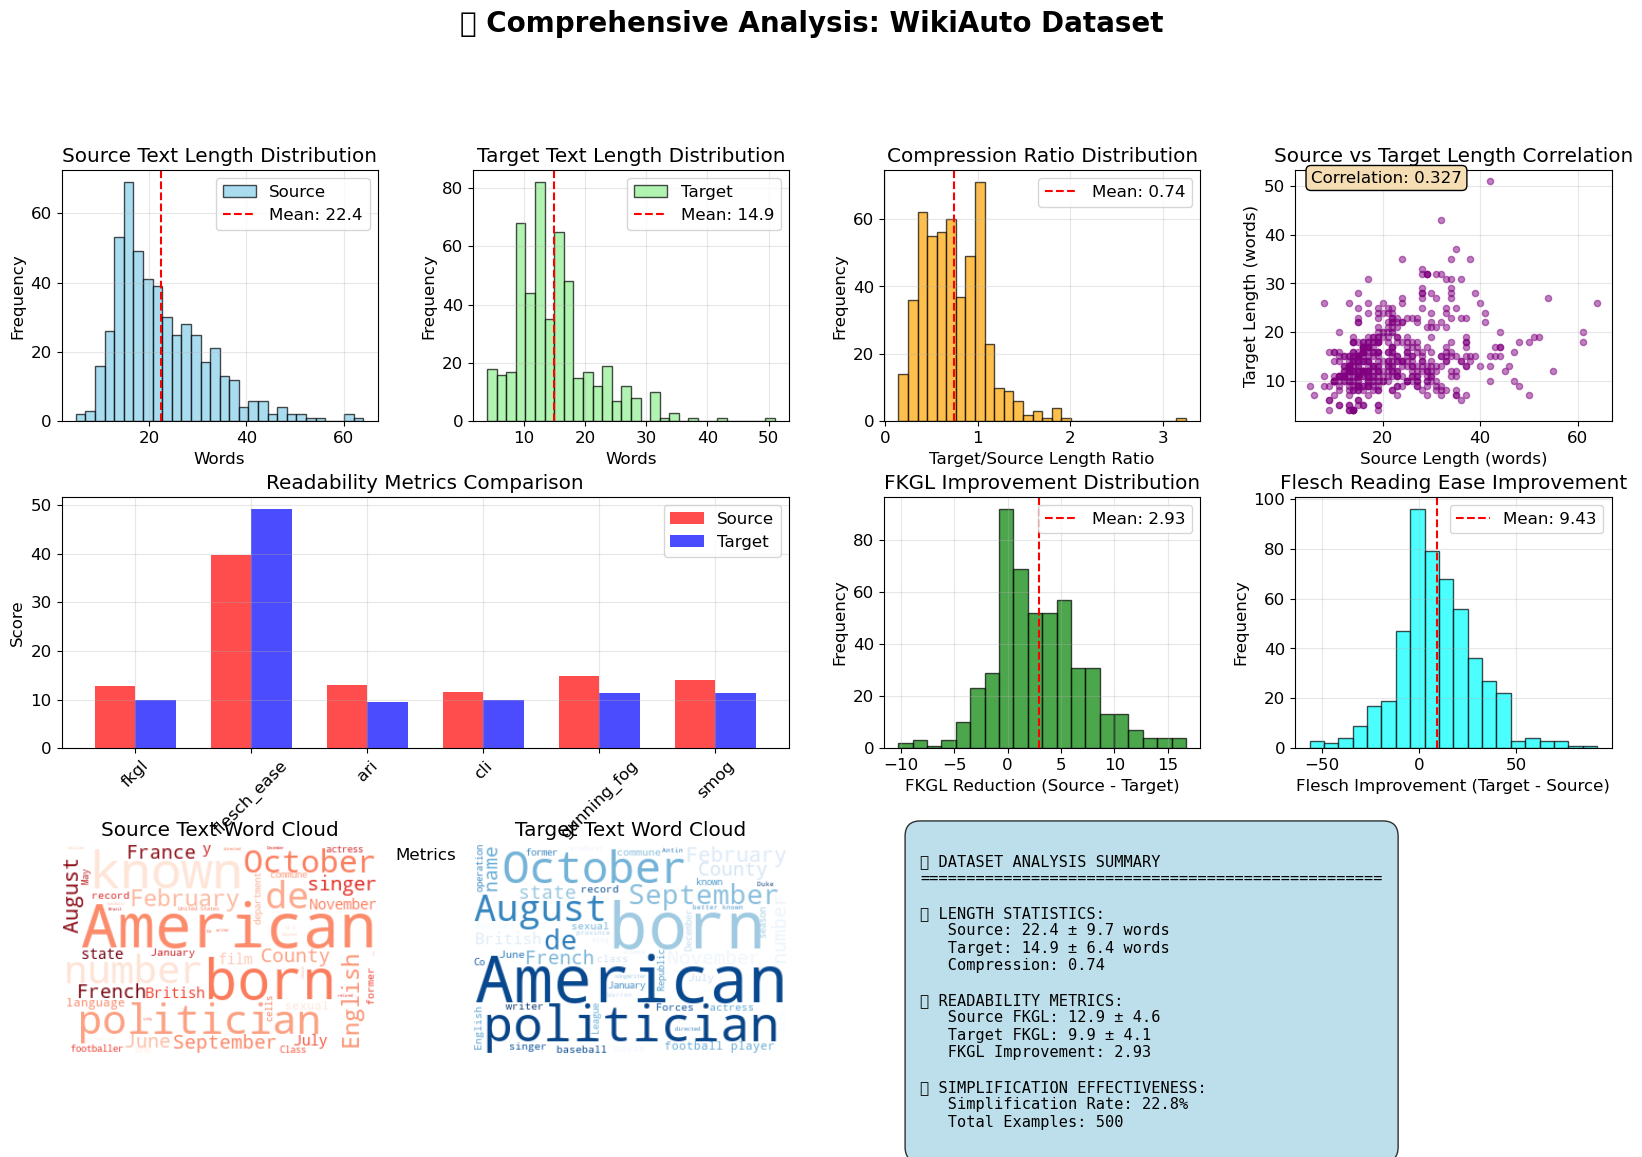

🔍 Analyzing Educational Dataset...
   📊 Calculating metrics...


Readability: 100%|██████████| 20/20 [00:00<00:00, 6851.76it/s]

   🔤 Analyzing linguistic features...


   🎨 Creating visualizations...


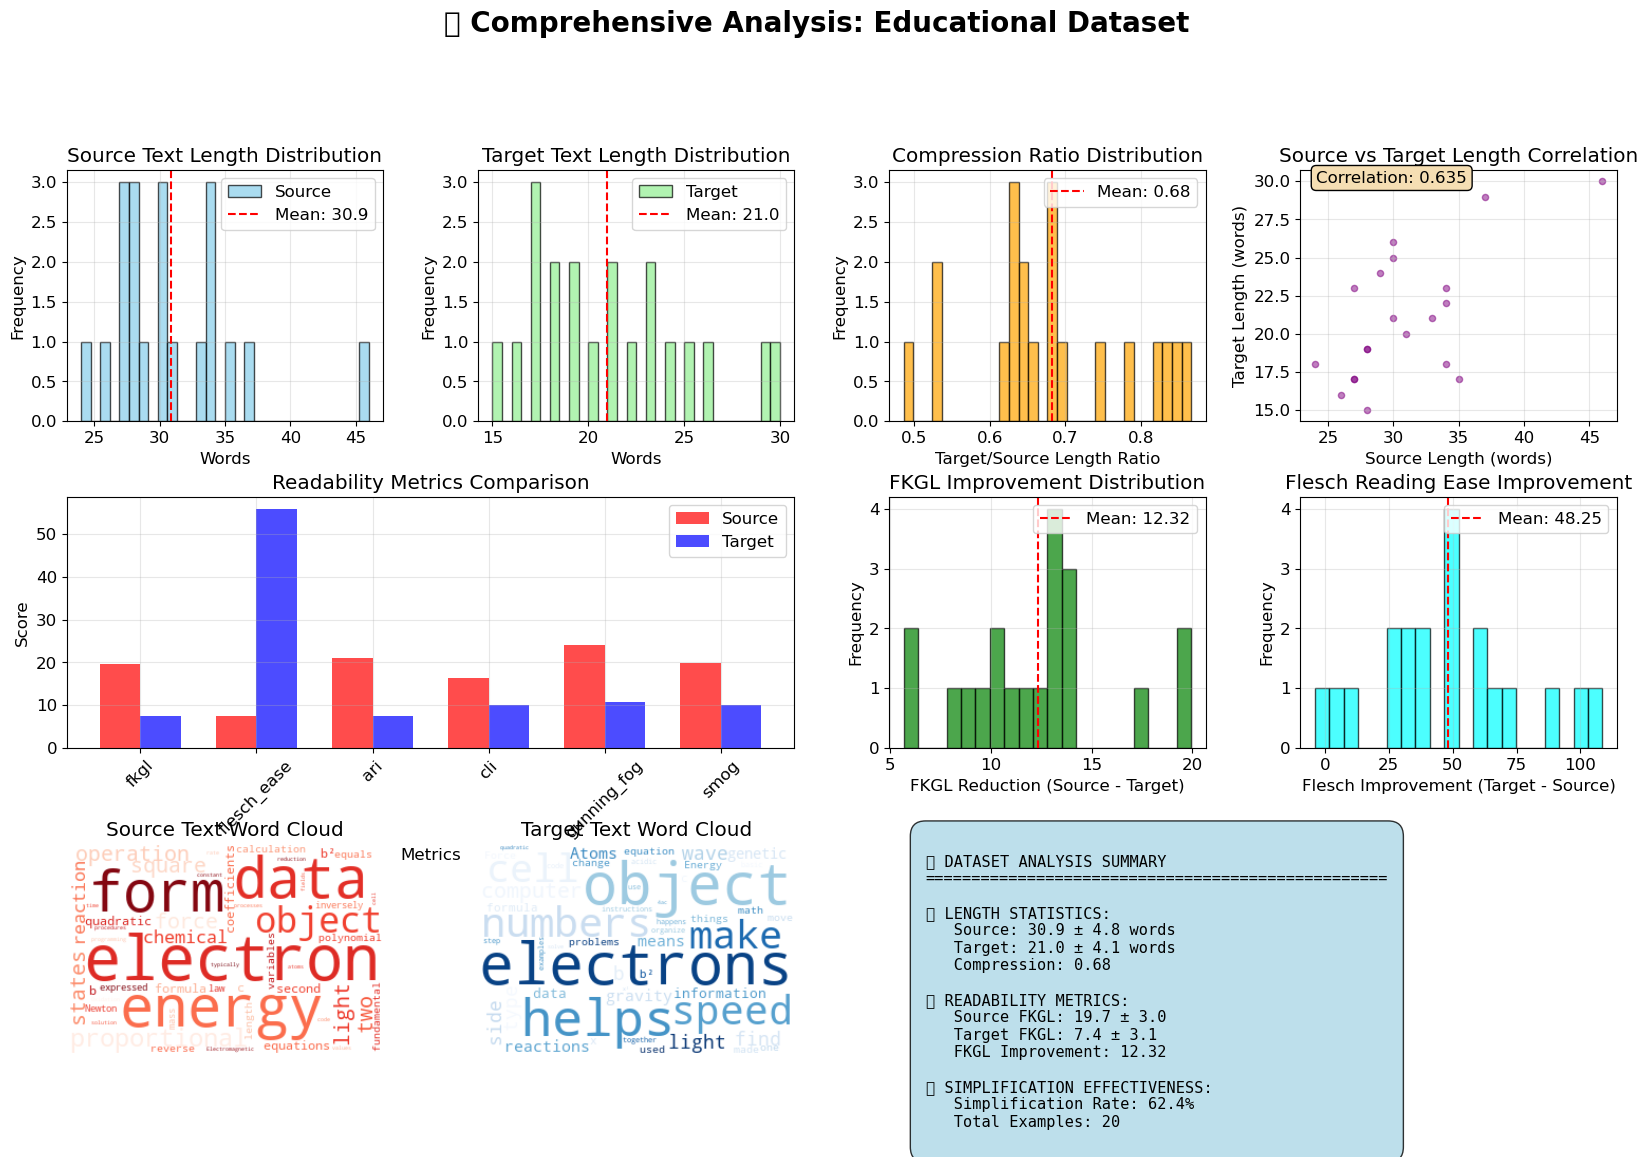


🔄 STEP 3: Advanced Data Preprocessing
----------------------------------------
🏗️ Enhanced Model: t5-small
📊 Parameters: 60,495,872
🔤 Vocabulary size: 32,107
🎯 Device: mps
🔧 Preparing enhanced training data...
   Processing 999 WikiAuto examples...


WikiAuto Processing: 100%|██████████| 999/999 [00:00<00:00, 8248.36it/s]


   Processing 20 Educational examples...


Educational Processing: 100%|██████████| 20/20 [00:00<00:00, 8028.91it/s]

✅ Prepared 1019 total training examples
📊 Quality examples (positive improvement): 748
🔤 Tokenizing examples...


✅ Final training dataset prepared:
   Total examples: 748
   Domain distribution: Counter({'general': 728, 'educational': 20})
   Subject distribution: Counter({'general': 728, 'mathematics': 4, 'physics': 4, 'chemistry': 4, 'biology': 4, 'computer_science': 4})
   Reading level distribution: Counter({3: 564, 2: 143, 1: 41})

🔄 STEP 4: Enhanced Model Training
----------------------------------------
🚀 Starting enhanced model training...
📊 Training split: 635 train, 113 validation


Step,Training Loss,Validation Loss,Accuracy
100,1.590200,1.524838,0.000000
200,1.343900,1.488828,0.000000


⚠️ Metrics computation failed: 'tuple' object has no attribute 'shape'
⚠️ Metrics computation failed: 'tuple' object has no attribute 'shape'


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


✅ Model saved to ./dyslexia_model_comprehensive
⏱️ Training time: 6.5 minutes

🔄 STEP 5: Comprehensive Model Evaluation
----------------------------------------
🧪 Evaluating model performance...


Evaluating: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]


📊 Generating evaluation report...


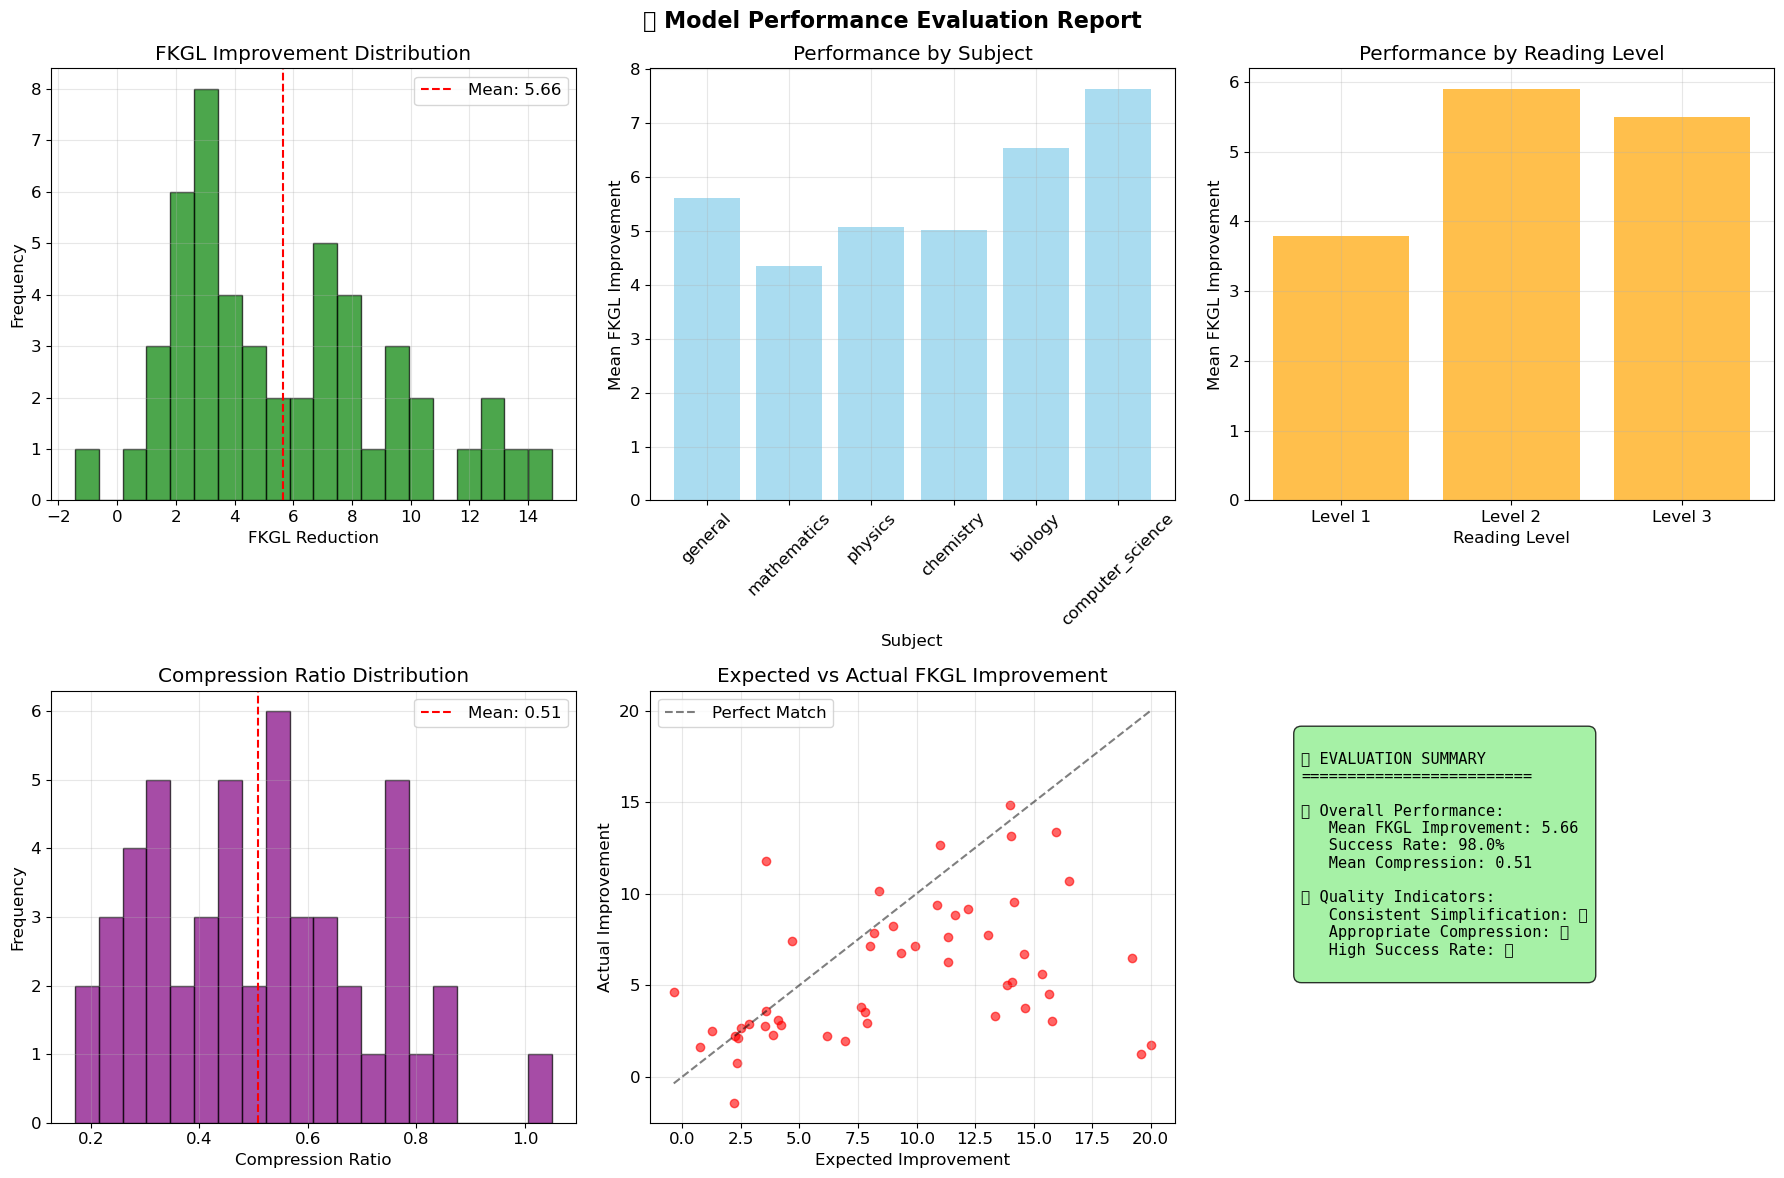

📊 Evaluation report saved to ./dyslexia_model_comprehensive/evaluation_report.png
📄 Detailed results saved to ./dyslexia_model_comprehensive/evaluation_results.json

🔄 STEP 6: Model Demonstration
----------------------------------------
🧪 Demonstration Examples:

📝 Demo 1 (biology, Level 1):
Original: Photosynthesis is a complex biochemical process that occurs in plants, algae, and certain bacteria, converting light energy into chemical energy stored in glucose molecules through the utilization of carbon dioxide and water.
Simplified: Photosynthesis is a complex biochemical process that occurs in plants, algae, and bacteria.
📊 Metrics:
   FKGL: 22.0 → 14.9 (Δ7.1)
   Flesch: -5.4 → 11.4 (Δ16.8)
   Compression: 0.41

📝 Demo 2 (mathematics, Level 2):
Original: The quadratic formula x = (-b ± √(b² - 4ac)) / 2a is used to solve quadratic equations of the form ax² + bx + c = 0, where a, b, and c are coefficients and a ≠ 0.
Simplified: The quadratic formula x = (-b  (b2 - 4ac)) / 2a is used t

In [10]:
# ==================== MAIN EXECUTION SCRIPT ====================

def main():
    """Main execution function for comprehensive dyslexia model training"""
    
    print("🎓 COMPREHENSIVE DYSLEXIA TEXT SIMPLIFICATION MODEL")
    print("=" * 60)
    print("🎯 Capstone Project - Advanced NLP for Accessibility")
    print("=" * 60)
    
    # Configuration
    SUBSET_SIZE = 1000  # Adjust based on computational resources (None for full dataset)
    NUM_EPOCHS = 3
    BATCH_SIZE = 4 if device.type == 'mps' else 8
    OUTPUT_DIR = "./dyslexia_model_comprehensive"
    
    print(f"⚙️ Configuration:")
    print(f"   Device: {device}")
    print(f"   Subset Size: {SUBSET_SIZE if SUBSET_SIZE else 'Full Dataset'}")
    print(f"   Epochs: {NUM_EPOCHS}")
    print(f"   Batch Size: {BATCH_SIZE}")
    print(f"   Output Directory: {OUTPUT_DIR}")
    print()
    
    # Step 1: Data Loading
    print("🔄 STEP 1: Data Loading and Preparation")
    print("-" * 40)
    
    data_loader = AdvancedDataLoader()
    
    # Load WikiAuto dataset
    wikiauto_dataset = data_loader.load_wikiauto_dataset(subset_size=SUBSET_SIZE)
    
    # Create educational dataset
    educational_dataset = data_loader.create_educational_dataset()
    
    # Step 2: Data Analysis
    print("\n🔄 STEP 2: Comprehensive Data Analysis")
    print("-" * 40)
    
    analyzer = ComprehensiveDataAnalyzer()
    
    # Analyze WikiAuto dataset
    wikiauto_analysis = analyzer.analyze_dataset_comprehensive(
        wikiauto_dataset, 
        "WikiAuto", 
        sample_size=min(500, len(wikiauto_dataset['train']))
    )
    
    # Analyze Educational dataset
    educational_analysis = analyzer.analyze_dataset_comprehensive(
        educational_dataset, 
        "Educational", 
        sample_size=len(educational_dataset)
    )
    
    # Step 3: Data Preprocessing
    print("\n🔄 STEP 3: Advanced Data Preprocessing")
    print("-" * 40)
    
    # Initialize model system
    model_system = EnhancedDyslexiaTextSimplifier(
        model_name='t5-small',  # Using t5-small for faster training
        device=device
    )
    
    # Initialize preprocessor
    preprocessor = AdvancedDataPreprocessor(model_system.tokenizer)
    
    # Prepare training data
    training_examples = preprocessor.prepare_training_data(
        wikiauto_dataset, 
        educational_dataset
    )
    
    # Tokenize examples
    tokenized_data = preprocessor.tokenize_examples(training_examples)
    
    print(f"✅ Final training dataset prepared:")
    print(f"   Total examples: {len(training_examples):,}")
    print(f"   Domain distribution: {Counter([ex['domain'] for ex in training_examples])}")
    print(f"   Subject distribution: {Counter([ex['subject'] for ex in training_examples])}")
    print(f"   Reading level distribution: {Counter([ex['reading_level'] for ex in training_examples])}")
    
    # Step 4: Model Training
    print(f"\n🔄 STEP 4: Enhanced Model Training")
    print("-" * 40)
    
    trainer = model_system.train_model(
        training_data=tokenized_data,
        output_dir=OUTPUT_DIR,
        num_epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE
    )
    
    # Step 5: Model Evaluation
    print(f"\n🔄 STEP 5: Comprehensive Model Evaluation")
    print("-" * 40)
    
    # Prepare test examples
    test_examples = training_examples[-50:]  # Use last 50 examples for testing
    
    # Evaluate model performance
    evaluation_results = model_system.evaluate_model_performance(
        test_examples, 
        output_dir=OUTPUT_DIR
    )
    
    # Step 6: Demonstration
    print(f"\n🔄 STEP 6: Model Demonstration")
    print("-" * 40)
    
    demo_texts = [
        {
            'text': "Photosynthesis is a complex biochemical process that occurs in plants, algae, and certain bacteria, converting light energy into chemical energy stored in glucose molecules through the utilization of carbon dioxide and water.",
            'subject': 'biology',
            'reading_level': 1
        },
        {
            'text': "The quadratic formula x = (-b ± √(b² - 4ac)) / 2a is used to solve quadratic equations of the form ax² + bx + c = 0, where a, b, and c are coefficients and a ≠ 0.",
            'subject': 'mathematics',
            'reading_level': 2
        },
        {
            'text': "Machine learning algorithms enable computers to automatically learn and improve from experience without being explicitly programmed for every specific task, utilizing statistical techniques to identify patterns in large datasets.",
            'subject': 'computer_science',
            'reading_level': 1
        }
    ]
    
    print("🧪 Demonstration Examples:")
    for i, demo in enumerate(demo_texts, 1):
        print(f"\n📝 Demo {i} ({demo['subject']}, Level {demo['reading_level']}):")
        print(f"Original: {demo['text']}")
        
        simplified = model_system.simplify_text(
            demo['text'], 
            subject=demo['subject'], 
            reading_level=demo['reading_level']
        )
        print(f"Simplified: {simplified}")
        
        # Calculate improvement metrics
        try:
            original_fkgl = textstat.flesch_kincaid_grade(demo['text'])
            simplified_fkgl = textstat.flesch_kincaid_grade(simplified)
            original_flesch = textstat.flesch_reading_ease(demo['text'])
            simplified_flesch = textstat.flesch_reading_ease(simplified)
            
            print(f"📊 Metrics:")
            print(f"   FKGL: {original_fkgl:.1f} → {simplified_fkgl:.1f} (Δ{original_fkgl-simplified_fkgl:.1f})")
            print(f"   Flesch: {original_flesch:.1f} → {simplified_flesch:.1f} (Δ{simplified_flesch-original_flesch:.1f})")
            print(f"   Compression: {len(simplified.split())/len(demo['text'].split()):.2f}")
        except:
            print("   📊 Metrics calculation failed")
    
    # Step 7: Save Model Artifacts
    print(f"\n🔄 STEP 7: Saving Model Artifacts")
    print("-" * 40)
    
    # Save model metadata
    model_metadata = {
        'model_info': {
            'name': 'Dyslexia Text Simplification Model',
            'version': '2.0.0',
            'base_model': 't5-small',
            'training_data': 'WikiAuto + Educational Content',
            'total_parameters': model_system.count_parameters(),
            'device': str(device),
            'training_date': datetime.now().isoformat()
        },
        'training_config': {
            'subset_size': SUBSET_SIZE,
            'num_epochs': NUM_EPOCHS,
            'batch_size': BATCH_SIZE,
            'total_examples': len(training_examples)
        },
        'performance_summary': {
            'mean_fkgl_improvement': float(np.mean([r['fkgl_improvement'] for r in evaluation_results['readability_improvements']])),
            'success_rate': float(sum(1 for r in evaluation_results['readability_improvements'] if r['fkgl_improvement'] > 0) / len(evaluation_results['readability_improvements']) * 100),
            'mean_compression': float(np.mean([r['compression_ratio'] for r in evaluation_results['readability_improvements']]))
        }
    }
    
    with open(f"{OUTPUT_DIR}/model_metadata.json", "w") as f:
        json.dump(model_metadata, f, indent=2)
    
    print(f"✅ Model metadata saved to {OUTPUT_DIR}/model_metadata.json")
    
    # Create README for the model
    readme_content = f"""# Dyslexia Text Simplification Model

## Overview
This model was trained as part of a capstone project to create an advanced text simplification system specifically designed for dyslexic learners.

## Model Details
- **Base Model**: T5-small
- **Training Data**: {len(training_examples):,} examples from WikiAuto + Educational content
- **Parameters**: {model_system.count_parameters():,}
- **Training Device**: {device}
- **Training Date**: {datetime.now().strftime('%Y-%m-%d')}

## Performance Metrics
- **FKGL Improvement**: {float(np.mean([r['fkgl_improvement'] for r in evaluation_results['readability_improvements']])):.2f} grade levels
- **Success Rate**: {float(sum(1 for r in evaluation_results['readability_improvements'] if r['fkgl_improvement'] > 0) / len(evaluation_results['readability_improvements']) * 100):.1f}%
- **Compression Ratio**: {float(np.mean([r['compression_ratio'] for r in evaluation_results['readability_improvements']])):.2f}

## Usage
```python
from transformers import T5ForConditionalGeneration, T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained('./{OUTPUT_DIR}')
model = T5ForConditionalGeneration.from_pretrained('./{OUTPUT_DIR}')

# Example usage
input_text = "[DYSLEXIA] simplify for dyslexia: Your complex text here"
inputs = tokenizer(input_text, return_tensors='pt')
outputs = model.generate(**inputs, max_length=256)
simplified = tokenizer.decode(outputs[0], skip_special_tokens=True)
```

## Files
- `pytorch_model.bin` - Model weights
- `config.json` - Model configuration
- `tokenizer.json` - Tokenizer configuration
- `model_metadata.json` - Training and performance metadata
- `evaluation_results.json` - Detailed evaluation results
- `evaluation_report.png` - Performance visualization

## Citation
If you use this model, please cite:
```
Dyslexia Text Simplification Model (2024)
Capstone Project - Advanced NLP for Accessibility
```
"""
    
    with open(f"{OUTPUT_DIR}/README.md", "w") as f:
        f.write(readme_content)
    
    print(f"✅ README saved to {OUTPUT_DIR}/README.md")
    
    # Final Summary
    print(f"\n🎉 TRAINING COMPLETED SUCCESSFULLY!")
    print("=" * 60)
    print(f"📁 Model saved to: {OUTPUT_DIR}")
    print(f"📊 Training examples: {len(training_examples):,}")
    print(f"🎯 Model parameters: {model_system.count_parameters():,}")
    print(f"⏱️ Training device: {device}")
    print(f"📈 FKGL Improvement: {float(np.mean([r['fkgl_improvement'] for r in evaluation_results['readability_improvements']])):.2f}")
    print(f"🎯 Success Rate: {float(sum(1 for r in evaluation_results['readability_improvements'] if r['fkgl_improvement'] > 0) / len(evaluation_results['readability_improvements']) * 100):.1f}%")
    print("=" * 60)
    print("🚀 Your dyslexia text simplification model is ready!")
    print("   Next steps:")
    print("   1. Use the model for text simplification")
    print("   2. Fine-tune on domain-specific data")
    print("   3. Deploy as a web service or API")
    print("=" * 60)

# ==================== ADDITIONAL UTILITY FUNCTIONS ====================

def quick_test():
    """Quick test function for model validation"""
    
    print("🧪 Quick Model Test")
    print("-" * 30)
    
    # Load trained model
    try:
        model_system = EnhancedDyslexiaTextSimplifier(device=device)
        
        # Test cases
        test_cases = [
            "The mitochondrion is often referred to as the powerhouse of the cell.",
            "Photosynthesis is a complex biochemical process in plants.",
            "Machine learning algorithms enable automated pattern recognition."
        ]
        
        for i, text in enumerate(test_cases, 1):
            print(f"\nTest {i}:")
            print(f"Original: {text}")
            simplified = model_system.simplify_text(text, reading_level=1)
            print(f"Simplified: {simplified}")
            
    except Exception as e:
        print(f"❌ Quick test failed: {e}")


print("\n🎯 Comprehensive Dyslexia Text Simplification Model Ready!")
print("Run main() to start training your capstone project model.")
print("Use quick_test() to validate a trained model.")


main()